Selected example studies:
      patient_id            study_id  target  \
244    401422755  DeepDeauville 1355       1   
997    401742345  DeepDeauville 0448       1   
999    401742345  DeepDeauville 0611       1   
2331   401369194  DeepDeauville 0939       1   
106    401422549  DeepDeauville 1639       1   
992    401742345  DeepDeauville 0532       1   
1656   401417576  DeepDeauville 1465       1   
2777   401370278  DeepDeauville 0677       1   
599    401310734  DeepDeauville 0208       1   
1145   401385945  DeepDeauville 0870       1   

                               filename  
244   images/DeepDeauville 1355_cor.npy  
997   images/DeepDeauville 0448_sag.npy  
999   images/DeepDeauville 0611_sag.npy  
2331  images/DeepDeauville 0939_sag.npy  
106   images/DeepDeauville 1639_cor.npy  
992   images/DeepDeauville 0532_cor.npy  
1656  images/DeepDeauville 1465_cor.npy  
2777  images/DeepDeauville 0677_sag.npy  
599   images/DeepDeauville 0208_sag.npy  
1145  images/DeepDeauvill

/home/mezher/Documents/Deauville_DeepLearning/thesis/lib/python3.10/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


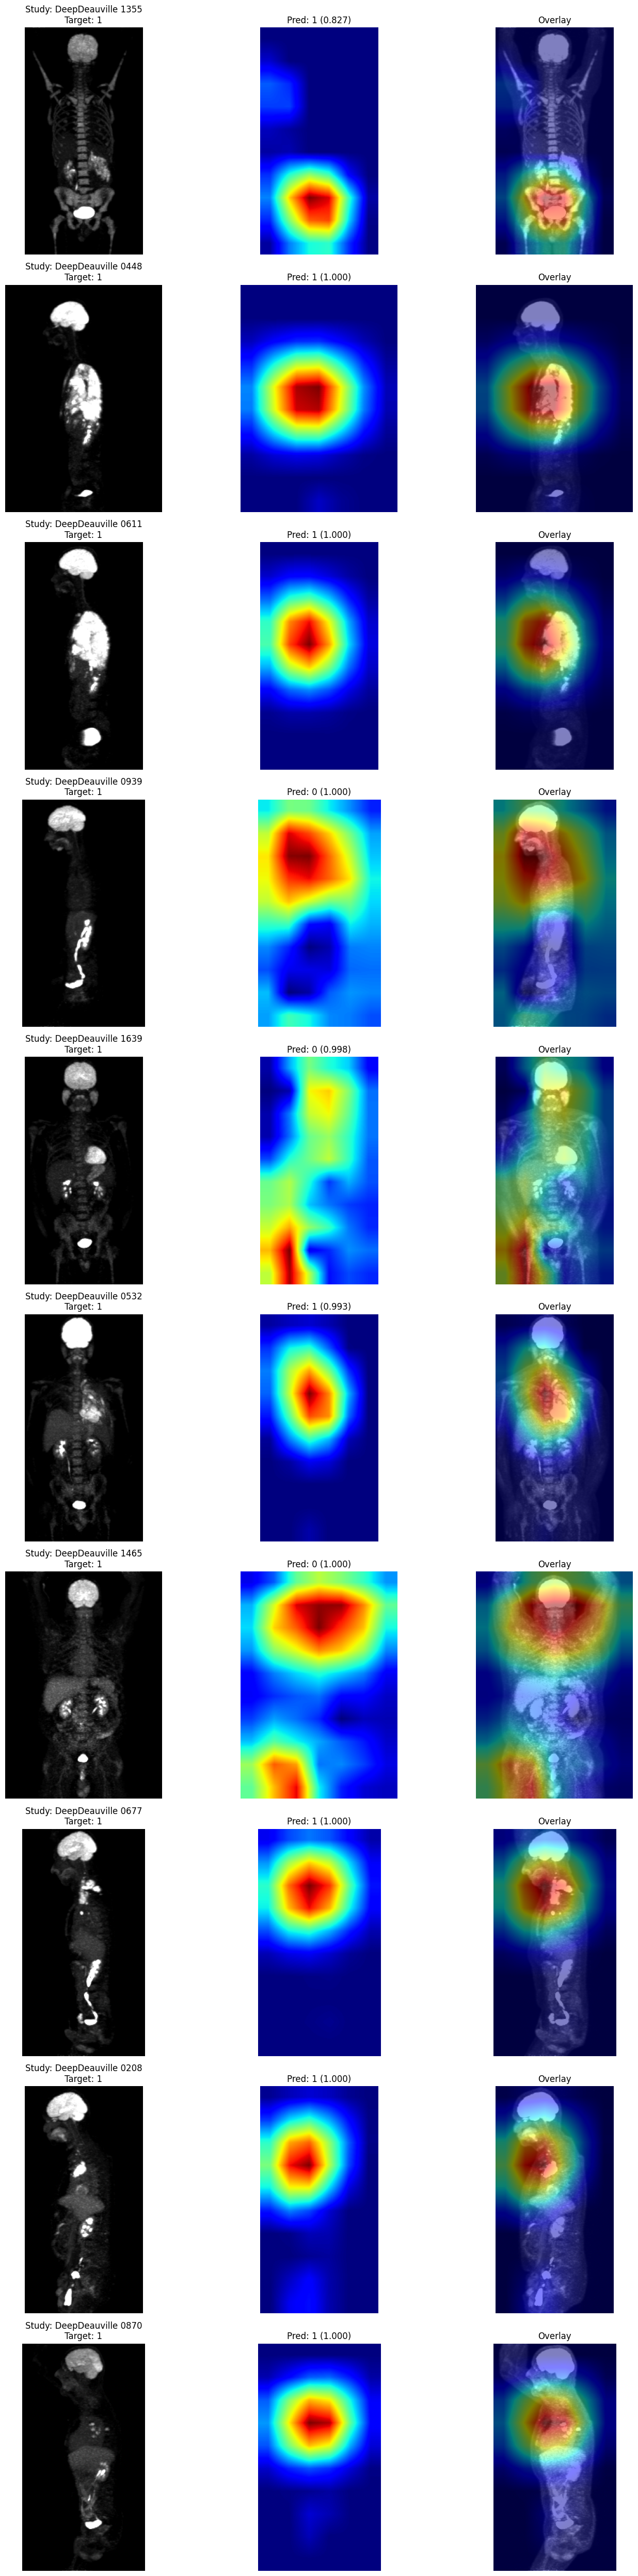

In [17]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2  # for resizing heatmap if needed
import random
import torch.nn.functional as F

# Set global seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Import your model helper from utils.py
from utils import get_model

# --- Define the GradCAM class if not already imported ---
class GradCAM:
    def __init__(self, model, target_layer_name):
        """
        model: your PyTorch model (e.g. your resnet-based model)
        target_layer_name: string name of the layer for Grad-CAM 
                           (e.g. 'features.7' in ResNet).
        """
        self.model = model
        self.target_layer = None
        self.gradients = None
        self.activations = None

        # Register forward & backward hooks
        for name, module in self.model.named_modules():
            if name == target_layer_name:
                self.target_layer = module
                self.target_layer.register_forward_hook(self.save_activation)
                self.target_layer.register_backward_hook(self.save_gradient)
                break

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        # grad_output is a tuple; we take the first element
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, class_idx=None):
        """
        Generates Grad-CAM for the given input_tensor (1 x C x H x W).
        If class_idx is None, we take the predicted class with max logit.
        Returns: a heatmap (2D) upsampled to the input size.
        """
        self.model.eval()
        # 1) Forward pass
        output = self.model(input_tensor)

        # If class_idx is not specified, choose the class with maximum score.
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        # 2) Zero gradients and backpropagate the score of the target class.
        self.model.zero_grad()
        score = output[0, class_idx]
        score.backward()

        # 3) Compute the channel-wise weights: mean of gradients over spatial dimensions.
        weights = torch.mean(self.gradients, dim=(0, 2, 3))  # shape: [channels]

        # 4) Compute the weighted combination of activations.
        activation = self.activations[0]  # remove batch dim => [channels, h, w]
        gradcam = torch.zeros(activation.shape[1:], dtype=activation.dtype, device=activation.device)
        for i, w in enumerate(weights):
            gradcam += w * activation[i, :, :]

        # 5) Apply ReLU.
        gradcam = F.relu(gradcam)

        # 6) Normalize the heatmap.
        gradcam = gradcam - gradcam.min()
        gradcam = gradcam / (gradcam.max() + 1e-8)

        # Convert to numpy array.
        gradcam = gradcam.cpu().numpy()

        # 7) Upsample to the size of the input tensor.
        _, _, H, W = input_tensor.shape
        gradcam = cv2.resize(gradcam, (W, H))

        return gradcam

# ----------------------------------------------------------------
# 1) Load the processed CSV file that lists all studies (data_resplit.csv)
data_resplit_path = r"/home/mezher/Documents/Deauville_DeepLearning/splitting/data_resplit.csv"
df_resplit = pd.read_csv(data_resplit_path)

# 2) Filter the DataFrame to only include test studies
df_test = df_resplit[df_resplit["set"] == "test"]

# 3) Preferably select studies with target=1; if <10, fallback to random from test
df_test_target1 = df_test[df_test["target"] == 1]
if len(df_test_target1) >= 10:
    df_examples = df_test_target1.sample(10, random_state=42)
else:
    df_examples = df_test.sample(10, random_state=42)

print("Selected example studies:")
print(df_examples[["patient_id", "study_id", "target", "filename"]])

# 4) Instantiate your model and load checkpoint
model = get_model(cls_arch="simple", hidden_dim=256, dropout=0.3)

checkpoint_path = r"/home/mezher/Documents/Deauville_DeepLearning/training_results/checkpoint_split0_run12.pth"
ch = torch.load(checkpoint_path, map_location="cuda",weights_only=False)  # or map_location="cuda" if you prefer
if "state_dict" in ch:
    model.load_state_dict(ch["state_dict"])
else:
    # In case the checkpoint is just a state_dict, not a dict with "state_dict" key
    model.load_state_dict(ch)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# 5) Instantiate GradCAM, targeting 'features.7'
gradcam = GradCAM(model, target_layer_name='features.7')

# 6) Prepare to plot 10 examples: 10 rows × 3 columns
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(15, 5 * 10))

for idx, (_, row) in enumerate(df_examples.iterrows()):
    # 6a) Construct full image path
    images_dir = r"/home/mezher/Documents/Deauville_DeepLearning/splitting/images"
    image_path = os.path.join(images_dir, os.path.basename(row["filename"]))

    # 6b) Load MIP and convert to torch tensor
    original_mip = np.load(image_path)  # shape (310, 310)
    mip_tensor = torch.tensor(original_mip).unsqueeze(0).unsqueeze(0).float().to(device)

    # 6c) Get model prediction
    output = model(mip_tensor)
    predicted_class = torch.argmax(output, dim=1).item()
    predicted_prob = F.softmax(output, dim=1)[0, predicted_class].item()

    # 6d) Generate GradCAM heatmap
    heatmap = gradcam.generate(mip_tensor)

    # 6e) Normalize original MIP for visualization
    lower, upper = np.percentile(original_mip, [5, 95])
    norm_mip = (original_mip - lower) / (upper - lower + 1e-8)
    norm_mip = np.clip(norm_mip, 0, 1)

    # 6f) Create overlay
    jetmap = plt.get_cmap('jet')(heatmap)[:, :, :3]
    norm_mip_rgb = np.dstack([norm_mip] * 3)
    alpha = 0.5
    overlay = alpha * jetmap + (1 - alpha) * norm_mip_rgb

    # 6g) Plot
    # Original MIP
    ax_orig = axes[idx, 0]
    ax_orig.imshow(original_mip, cmap='gray', vmin=1, vmax=10)
    ax_orig.set_title(f"Study: {row['study_id']}\nTarget: {row['target']}")
    ax_orig.axis("off")

    # Heatmap
    ax_heat = axes[idx, 1]
    ax_heat.imshow(heatmap, cmap='jet')
    ax_heat.set_title(f"Pred: {predicted_class} ({predicted_prob:.3f})")
    ax_heat.axis("off")

    # Overlay
    ax_overlay = axes[idx, 2]
    ax_overlay.imshow(overlay)
    ax_overlay.set_title("Overlay")
    ax_overlay.axis("off")

plt.tight_layout()
plt.show()


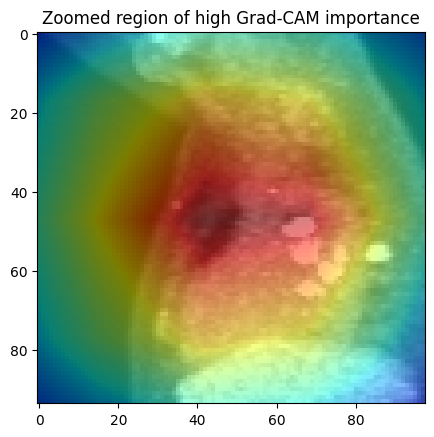

In [18]:
mask = (heatmap > 0.5)
rows = np.any(mask, axis=1)
cols = np.any(mask, axis=0)
if np.any(rows) and np.any(cols):
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    # expand a bit
    margin = 5
    rmin = max(rmin - margin, 0)
    rmax = min(rmax + margin, heatmap.shape[0])
    cmin = max(cmin - margin, 0)
    cmax = min(cmax + margin, heatmap.shape[1])
    
    # Crop the overlay
    zoomed_overlay = overlay[rmin:rmax, cmin:cmax, :]
    
    plt.figure(figsize=(5,5))
    plt.imshow(zoomed_overlay)
    plt.title("Zoomed region of high Grad-CAM importance")
    plt.show()


In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16,4))

axes[0].imshow(original_mip, cmap='gray', vmin=1, vmax=10)
axes[0].set_title("Original MIP")

axes[1].imshow(heatmap, cmap='jet')
axes[1].set_title("Heatmap")

axes[2].imshow(overlay)
axes[2].set_title("Overlay")

axes[3].imshow(zoomed_overlay)
axes[3].set_title("Zoomed Region")

for ax in axes:
    ax.axis('off')

plt.suptitle("Grad-CAM Visualization", fontsize=16)
plt.tight_layout()
plt.show()
